# Error type prediction of an optical assembly for MKS Inc.
The dataset 'MKS_data.csv' contains the following information:
* Trial column (not important)
* 36 measured Zernike coefficients.
* The measured modulation transfer function (MTF) column.
* The EFL column represents the type of lens used in the experiment (z1 or z2).
* The name column indicates the type of optical error (e.g., Flatness s1 E7, Radius s2 E1, etc.). The error column indicates the size of the optical error and is usually +2 or -2, but sometimes also a different value. We will ignore this column.

### Goal:
Given the Zernike coefficients (columns c2, c3, c4,..., c37) and the MTF value, we must predict the type of optical error (column name).
Note that each error type in the ‘name’ column is composed of an optical error type and the optical element that suffers that error type. For example, the error type “Flatness s1 E7” indicates that the optical error type is “Flatness s1” and the optical element is “E7”. Similarly, for the error type “Radius s2 E1”, the optical error type is “Radius s2” and the optical element is “E1”.


## data loading

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. Data loading and initial cleaning ---
file_path = 'dominant_error_680084_twoZooms_Monte-Carlo_100K_systems_clean.csv'
df = pd.read_csv(file_path)

# Remove rows missing 'name' label and unnecessary columns
df = df.dropna(subset=['name'])
df = df.drop(columns=['Trial', 'error'], errors='ignore')

# --- 2. Feature Engineering ---

# Convert EFL column (categorical) to numerical values (0 and 1)
df['EFL_num'] = df['EFL'].map({'z1': 0, 'z2': 1})

# Define feature columns list: converted EFL, Zernike coefficients (c2-c37), and MTF column
feature_cols = ['EFL_num'] + [f'c{i}' for i in range(2, 38)] + ['MTF']
X = df[feature_cols].values

## each error in the 'name' column consists of [optical error]+[optical element], for example: 'Tilt E6' ([Tilt]+[E6])

In [32]:
# --- 3. Target Columns Processing (Labels) ---

# Function to split the 'name' column into two components: error type and optical element
def split_error_name(name):
    parts = name.split()
    element = parts[-1]          # The last word is the element (e.g., E7)
    error_type = " ".join(parts[:-1]) # Everything before it is the error type
    return error_type, element

# Apply the splitting to the DataFrame
df['error_type'], df['element'] = zip(*df['name'].map(split_error_name))

# Encoding (Label Encoding) for three target levels
le_full = LabelEncoder()
le_type = LabelEncoder()
le_elem = LabelEncoder()

y_full = le_full.fit_transform(df['name'])        # For models 1 and 4
y_type = le_type.fit_transform(df['error_type'])  # For models 2 and 3
y_elem = le_elem.fit_transform(df['element'])     # For models 2 and 3

## train/val/test split

In [33]:
# --- 4. Data Splitting (Train, Val, Test) ---

# Split into 60% training and remaining 40% (to be split further)
# Using stratify on y_full ensures equal representation of all 80 classes in all sets
indices = np.arange(len(df))
idx_train, idx_temp = train_test_split(
    indices, test_size=0.4, random_state=42, stratify=y_full
)

# Split the remaining 40% into 20% validation and 20% test
idx_val, idx_test = train_test_split(
    idx_temp, test_size=0.5, random_state=42, stratify=y_full[idx_temp]
)

# Create the final sets
X_train, y_train = X[idx_train], y_full[idx_train]
X_val,   y_val   = X[idx_val],   y_full[idx_val]
X_test,  y_test  = X[idx_test],  y_full[idx_test]

# Create sub-targets for models 2 and 3 (using the same indices)
y_train_type, y_train_elem = y_type[idx_train], y_elem[idx_train]
y_val_type,   y_val_elem   = y_type[idx_val],   y_elem[idx_val]
y_test_type,  y_test_elem  = y_type[idx_test],  y_elem[idx_test]

In [34]:
# --- 5. Data Normalization (Scaling) ---
# Very important for neural networks (models 1-3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [35]:
# --- 6. Print Summary and Display Results (according to section 2) ---

print(f"--- Data Summary ---")
print(f"Total Samples: {len(df)}")
print(f"Features: {X.shape[1]} | Classes: {len(le_full.classes_)}")
print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")

# Number of samples per class in the test set (section 2)
test_names = le_full.inverse_transform(y_test)
print("\nTop 5 classes in Test Set:")
print(pd.Series(test_names).value_counts().head(5))

--- Data Summary ---
Total Samples: 200000
Features: 38 | Classes: 80
Train size: 120000 | Val size: 40000 | Test size: 40000

Top 5 classes in Test Set:
Flatness s1 E9    991
Flatness s1 E4    535
Thickness E9      526
Flatness s1 E8    526
Decenter E9       523
Name: count, dtype: int64


# Our models for investigation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from xgboost import XGBClassifier

# Define basic hyperparameters
INPUT_SIZE = 38  # EFL + c2-c37 + MTF
HIDDEN_SIZE = 128
NUM_CLASSES_FULL = 80
NUM_CLASSES_TYPE = 10
NUM_CLASSES_ELEM = 10
EMBED_DIM = 8

# -----------------------------------------
# Model 1: Neural Network (Direct Classifier)
# -----------------------------------------
class Model1DirectNN(nn.Module):
    def __init__(self):
        super(Model1DirectNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, NUM_CLASSES_FULL)
        )

    def forward(self, x):
        return self.network(x)

# -----------------------------------------
# Model 2: Type -> Element (Argmax + Embedding)
# -----------------------------------------

class Model2TypeFirstNN(nn.Module):
    """
    Stage 1: predict error TYPE
    Stage 2: predict ELEMENT conditioned on argmax(TYPE) via embedding
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_classes_type: int,
        num_classes_elem: int,
        embed_dim: EMBED_DIM,
        dropout: float = 0.0
    ):
        super().__init__()

        # Stage 1: TYPE
        self.type_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_size, num_classes_type)
        )

        # Embedding for argmax(TYPE)
        self.type_embedding = nn.Embedding(num_classes_type, embed_dim)

        # Stage 2: ELEMENT, conditioned on embedded TYPE
        self.elem_net = nn.Sequential(
            nn.Linear(input_size + embed_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_size, num_classes_elem)
        )

    def forward(self, x):
        # Stage 1
        type_logits = self.type_net(x)
        type_pred = type_logits.argmax(dim=1)
        type_emb = self.type_embedding(type_pred)

        # Stage 2
        x_concat = torch.cat([x, type_emb], dim=1)
        elem_logits = self.elem_net(x_concat)

        return type_logits, elem_logits


# -----------------------------------------
# Model 3: Element -> Type (Argmax + Embedding)
# -----------------------------------------

class Model3ElementFirstNN(nn.Module):
    """
    Stage 1: predict ELEMENT
    Stage 2: predict TYPE conditioned on argmax(ELEMENT) via embedding
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_classes_elem: int,
        num_classes_type: int,
        embed_dim: EMBED_DIM,
        dropout: float = 0.0
    ):
        super().__init__()

        # Stage 1: ELEMENT
        self.elem_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_size, num_classes_elem)
        )

        # Embedding for argmax(ELEMENT)
        self.elem_embedding = nn.Embedding(num_classes_elem, embed_dim)

        # Stage 2: TYPE, conditioned on embedded ELEMENT
        self.type_net = nn.Sequential(
            nn.Linear(input_size + embed_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_size, num_classes_type)
        )

    def forward(self, x):
        # Stage 1
        elem_logits = self.elem_net(x)
        elem_pred = elem_logits.argmax(dim=1)
        elem_emb = self.elem_embedding(elem_pred)

        # Stage 2
        x_concat = torch.cat([x, elem_emb], dim=1)
        type_logits = self.type_net(x_concat)

        return elem_logits, type_logits


# -----------------------------------------
# Model 4: XGBoost Classifier
# -----------------------------------------
def get_model4_xgboost(num_classes, n_estimators=250):
    return XGBClassifier(
        n_estimators=n_estimators, # Number of boosting rounds (trees to build).
        learning_rate=0.01,        # Step size shrinkage to prevent overfitting.
        max_depth=5,               # Maximum depth of a tree. Controls complexity.
        min_child_weight=5,        # Minimum sum of instance weight (hessian) needed in a child. Higher values prevent overfitting.
        gamma=1,                   # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        reg_lambda=10,             # L2 regularization term on weights. Higher values make models more conservative.
        subsample=0.8,             # Subsample ratio of the training instance. Prevents overfitting.
        colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree.
        objective="multi:softprob",# Specifies the learning task and the corresponding learning objective. 'multi:softprob' outputs predicted probability of each class.
        num_class=num_classes,     # Number of classes in the target variable.
        tree_method="hist",        # Algorithm used for tree construction. 'hist' for faster training on large datasets.
        device="cuda",             # Specifies the device to run on (GPU in this case, if available).
        early_stopping_rounds=30,  # Activates early stopping. Training stops if validation metric doesn't improve for 30 consecutive rounds.
        eval_metric=["mlogloss", "merror"], # ADDED: Evaluation metrics to be printed in `evals_result()`
        random_state=42            # Random seed for reproducibility.
    )

# Print model summary
print("Models defined:")
print("1. Model 1: Direct Name Classifier")
print("2. Model 2: Cascaded (Type -> Element)")
print("3. Model 3: Cascaded (Element -> Type)")
print("4. Model 4: XGBoost Ensemble")

Models defined:
1. Model 1: Direct Name Classifier
2. Model 2: Cascaded (Type -> Element)
3. Model 3: Cascaded (Element -> Type)
4. Model 4: XGBoost Ensemble


## For consistency

In [37]:
import random, torch
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# XGBoost Model

In [38]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"Memory Capacity: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Working on CPU. Check your settings!")

Working on CPU. Check your settings!


In [39]:
import numpy as np
import xgboost as xgb

# Data generation
X_small = np.random.randn(1000, 38).astype(np.float32)
y_small = np.random.randint(0, 80, size=1000)

try:
    # Key change: tree_method="hist" and device="cuda"
    m = xgb.XGBClassifier(
        tree_method="hist",
        device="cuda",
        n_estimators=5
    )
    m.fit(X_small, y_small)
    print("✅ XGBoost GPU is working (using device='cuda' parameter).")
except Exception as e:
    print("❌ XGBoost GPU is still not working. Error:\n", e)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:04:29] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:04:29] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost GPU עובד (באמצעות הפרמטר device='cuda').


In [40]:
import xgboost
print(xgboost.__version__)

3.1.3


In [ ]:
num_classes = len(le_full.classes_)  # Number of categories in the 'name' column

xgb_model = get_model4_xgboost(num_classes, n_estimators=250) # Pass 250 as the default

In [ ]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import xgboost as xgb

# --- Train with evaluation history (loss + accuracy curves) ---
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=10
)

results = xgb_model.evals_result()
train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]
train_acc  = [1 - e for e in results["validation_0"]["merror"]]
val_acc    = [1 - e for e in results["validation_1"]["merror"]]

if hasattr(xgb_model, 'best_iteration'):
    print(f"Best iteration: {xgb_model.best_iteration + 1}")

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:31:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:31:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:4.33665	validation_0-merror:0.70504	validation_1-mlogloss:4.33762	validation_1-merror:0.71480
[10]	validation_0-mlogloss:3.99113	validation_0-merror:0.62252	validation_1-mlogloss:4.00159	validation_1-merror:0.64082
[20]	validation_0-mlogloss:3.75936	validation_0-merror:0.60742	validation_1-mlogloss:3.77677	validation_1-merror:0.62543
[30]	validation_0-mlogloss:3.58361	validation_0-merror:0.59639	validation_1-mlogloss:3.60703	validation_1-merror:0.61538
[40]	validation_0-mlogloss:3.44216	validation_0-merror:0.58890	validation_1-mlogloss:3.47031	validation_1-merror:0.60947
[50]	validation_0-mlogloss:3.32424	validation_0-merror:0.58262	validation_1-mlogloss:3.35630	validation_1-merror:0.60300
[60]	validation_0-mlogloss:3.22271	validation_0-merror:0.57637	validation_1-mlogloss:3.25843	validation_1-merror:0.59813
[70]	validation_0-mlogloss:3.13491	validation_0-merror:0.57141	validation_1-mlogloss:3.17390	validation_1-merror:0.59472
[80]	validation_0-mlogloss:3.0559

In [ ]:
actual_rounds = len(train_loss)
rounds_seq = np.arange(1, actual_rounds + 1)

## Plot training curves


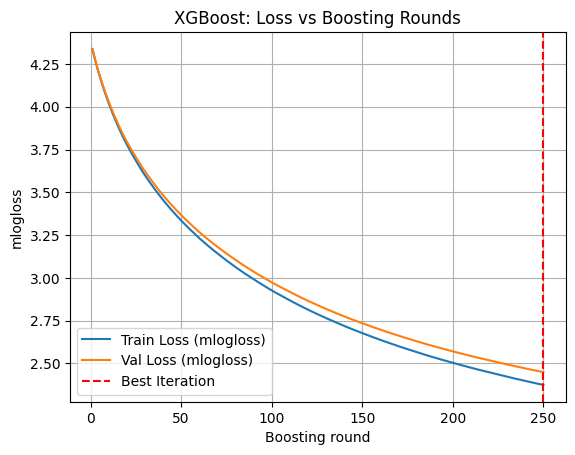

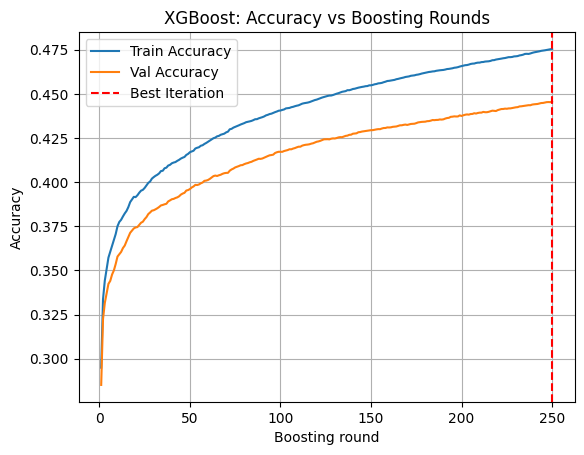

In [ ]:
# --- Loss curves ---plt.figure(figsize=(10,5))
plt.plot(rounds_seq, train_loss, label="Train Loss (mlogloss)")
plt.plot(rounds_seq, val_loss, label="Val Loss (mlogloss)")
if xgb_model.best_iteration is not None:
    plt.axvline(xgb_model.best_iteration + 1, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost: Loss vs Boosting Rounds")
plt.xlabel("Boosting round")
plt.ylabel("mlogloss")
plt.legend()
plt.grid(True)
plt.show()

# --- Accuracy curves ---plt.figure(figsize=(10,5))
plt.plot(rounds_seq, train_acc, label="Train Accuracy")
plt.plot(rounds_seq, val_acc, label="Val Accuracy")
if xgb_model.best_iteration is not None:
    plt.axvline(xgb_model.best_iteration + 1, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost: Accuracy vs Boosting Rounds")
plt.xlabel("Boosting round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Loss and accuracy plots show XGBoost learned over 250 rounds; training and validation metrics improved, but some overfitting is visible. The model ran to its maximum rounds without early stopping.

    feature  importance
0   EFL_num    0.122265
17      c18    0.063061
3        c4    0.060087
31      c32    0.057142
12      c13    0.042763
5        c6    0.040320
2        c3    0.038419
21      c22    0.036760
37      MTF    0.033450
32      c33    0.032027


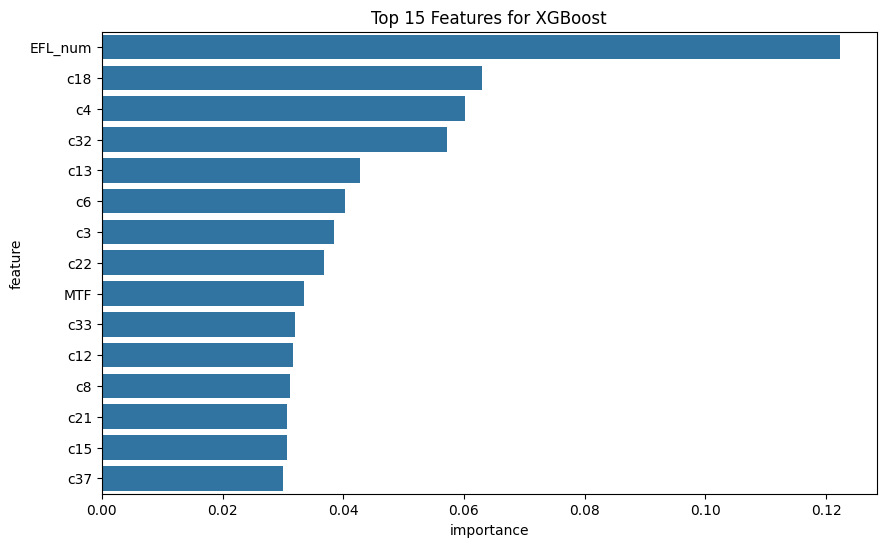

In [49]:
import pandas as pd

# שליפת חשיבות המאפיינים
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importances.head(10))

# הצגה גרפית
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(15))
plt.title("Top 15 Features for XGBoost")
plt.show()

The feature importance plot shows that **EFL_num is the most influential feature for the XGBoost model and it might be the reason for the mild overfitting I encountered**. I'll therefore **split the data by Z1 and Z2 focusing and check if it leads to any improvement**.

## fighting overfitting:

In [50]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define helper functions (define first) ---

def get_zoom_model(n_classes):
    return XGBClassifier(
        n_estimators=600,
        learning_rate=0.02,
        max_depth=5,
        min_child_weight=5,
        reg_lambda=15,
        gamma=1,
        subsample=0.8,
        colsample_bytree=0.6,
        tree_method="hist",
        device="cuda",
        num_class=n_classes,
        objective="multi:softprob",
        eval_metric=["mlogloss", "merror"],
        early_stopping_rounds=40,
        random_state=42
    )

In [51]:
def train_zoom_refined(X_t, y_t_orig, X_v, y_v_orig, title):
    print(f"\n>>> Preparing and Training {title}...")

    # Re-encoding to sequential labels (0, 1, 2...)
    le_zoom = LabelEncoder()
    y_t_new = le_zoom.fit_transform(y_t_orig)
    y_v_new = le_zoom.transform(y_v_orig)

    n_classes = len(le_zoom.classes_)
    print(f"Number of unique classes in this zoom: {n_classes}")

    model = get_zoom_model(n_classes)
    model.fit(
        X_t, y_t_new,
        eval_set=[(X_t, y_t_new), (X_v, y_v_new)],
        verbose=100
    )

    # Extract results
    res = model.evals_result()
    train_loss = res["validation_0"]["mlogloss"]
    val_loss = res["validation_1"]["mlogloss"]

    # Calculate Accuracy from merror (accuracy = 1 minus error)
    train_acc = [1 - m for m in res["validation_0"]["merror"]]
    val_acc = [1 - m for m in res["validation_1"]["merror"]]

    x_axis = range(1, len(train_loss) + 1)

    # Create a plot with two graphs side by side
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Graph 1: Loss
    ax[0].plot(x_axis, train_loss, label="Train Loss")
    ax[0].plot(x_axis, val_loss, label="Val Loss")
    ax[0].set_title(f"Loss Curve - {title}")
    ax[0].set_xlabel("Rounds")
    ax[0].set_ylabel("LogLoss")
    ax[0].legend()
    ax[0].grid(True)

    # Graph 2: Accuracy
    ax[1].plot(x_axis, train_acc, label="Train Accuracy")
    ax[1].plot(x_axis, val_acc, label="Val Accuracy")
    ax[1].set_title(f"Accuracy Curve - {title}")
    ax[1].set_xlabel("Rounds")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, le_zoom

Z1: 60175 samples, 80 unique names
Z2: 59825 samples, 80 unique names
Z1 Check: Train=60175, Val=19897
Z2 Check: Train=59825, Val=20103

>>> Preparing and Training Zoom 1 (Z1)...
Number of unique classes in this zoom: 80


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:58:09] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:58:09] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:4.32195	validation_0-merror:0.76371	validation_1-mlogloss:4.32389	validation_1-merror:0.77373
[100]	validation_0-mlogloss:2.63645	validation_0-merror:0.53894	validation_1-mlogloss:2.72511	validation_1-merror:0.57768
[200]	validation_0-mlogloss:2.22514	validation_0-merror:0.49514	validation_1-mlogloss:2.36512	validation_1-merror:0.55023
[300]	validation_0-mlogloss:2.01127	validation_0-merror:0.45791	validation_1-mlogloss:2.20312	validation_1-merror:0.53294
[400]	validation_0-mlogloss:1.86605	validation_0-merror:0.42318	validation_1-mlogloss:2.11285	validation_1-merror:0.52249
[500]	validation_0-mlogloss:1.75499	validation_0-merror:0.38875	validation_1-mlogloss:2.05669	validation_1-merror:0.51525
[599]	validation_0-mlogloss:1.66455	validation_0-merror:0.35849	validation_1-mlogloss:2.02001	validation_1-merror:0.51113


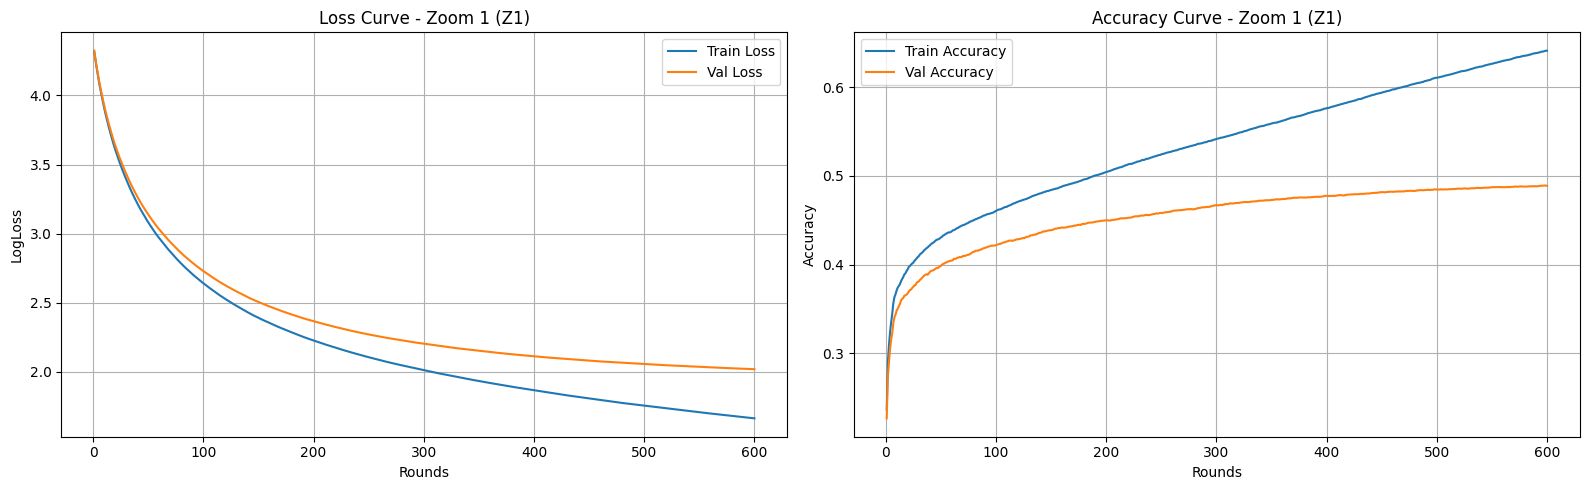


>>> Preparing and Training Zoom 2 (Z2)...
Number of unique classes in this zoom: 80


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:10:41] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [16:10:41] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:4.28801	validation_0-merror:0.66345	validation_1-mlogloss:4.28976	validation_1-merror:0.67184
[100]	validation_0-mlogloss:2.23458	validation_0-merror:0.47144	validation_1-mlogloss:2.30743	validation_1-merror:0.50410
[200]	validation_0-mlogloss:1.84276	validation_0-merror:0.43512	validation_1-mlogloss:1.95595	validation_1-merror:0.48610
[300]	validation_0-mlogloss:1.65856	validation_0-merror:0.39957	validation_1-mlogloss:1.81953	validation_1-merror:0.47446
[400]	validation_0-mlogloss:1.53937	validation_0-merror:0.36379	validation_1-mlogloss:1.75193	validation_1-merror:0.46849
[500]	validation_0-mlogloss:1.44827	validation_0-merror:0.33063	validation_1-mlogloss:1.71273	validation_1-merror:0.46311
[599]	validation_0-mlogloss:1.37389	validation_0-merror:0.30019	validation_1-mlogloss:1.68753	validation_1-merror:0.45948


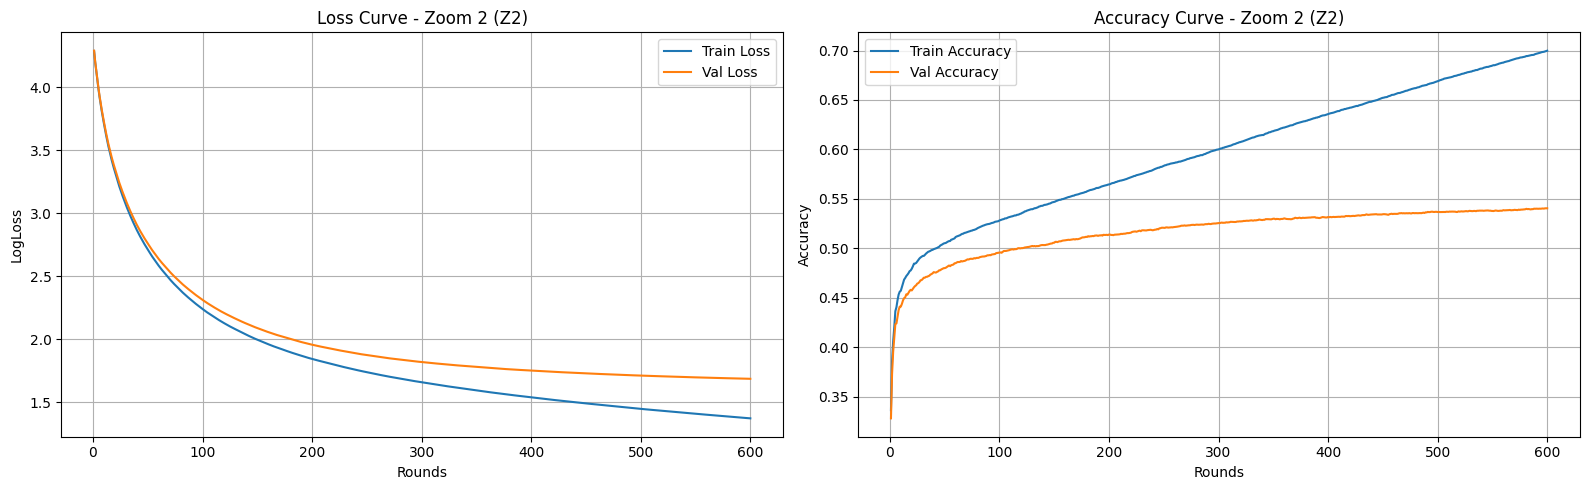

In [52]:
# --- 2. Secure data splitting (by EFL) ---

efl_all = df['EFL_num'].values
efl_train = efl_all[idx_train]
efl_val   = efl_all[idx_val]

mask_z1_train = (efl_train == 0)
mask_z2_train = (efl_train == 1)
mask_z1_val = (efl_val == 0)
mask_z2_val = (efl_val == 1)

# Creating the sets (removing the EFL column from features)
# --- Resplitting the data using actual names ---
# We pull the text directly from the original DataFrame by indices

# Z1 - Using names (Strings)
X_tr_z1 = X_train_scaled[mask_z1_train, 1:]
y_tr_z1 = df['name'].values[idx_train][mask_z1_train]

X_va_z1 = X_val_scaled[mask_z1_val, 1:]
y_va_z1 = df['name'].values[idx_val][mask_z1_val]

# Z2 - Using names (Strings)
X_tr_z2 = X_train_scaled[mask_z2_train, 1:]
y_tr_z2 = df['name'].values[idx_train][mask_z2_train]

X_va_z2 = X_val_scaled[mask_z2_val, 1:]
y_va_z2 = df['name'].values[idx_val][mask_z2_val]

print(f"Z1: {len(X_tr_z1)} samples, {len(np.unique(y_tr_z1))} unique names")
print(f"Z2: {len(X_tr_z2)} samples, {len(np.unique(y_tr_z2))} unique names")

# Size integrity check
print(f"Z1 Check: Train={len(X_tr_z1)}, Val={len(X_va_z1)}")
print(f"Z2 Check: Train={len(X_tr_z2)}, Val={len(X_va_z2)}")

# --- 3. Final run ---

model_z1, le_z1 = train_zoom_refined(X_tr_z1, y_tr_z1, X_va_z1, y_va_z1, "Zoom 1 (Z1)")
model_z2, le_z2 = train_zoom_refined(X_tr_z2, y_tr_z2, X_va_z2, y_va_z2, "Zoom 2 (Z2)")

The data was split into Z1 and Z2 categories, and separate XGBoost models were trained for each. Both models showed learning, with training accuracy improving significantly, but still displayed mild signs of overfitting.

**Note:**
80 classes is a challenge: In a problem with 80 options, accuracy of over 50% is a very impressive statistical achievement (*40 times better than random guessing*).

**Next step:**
I'll plot the confusion matrices and the generalized ROC curves to further investigate the model performance.

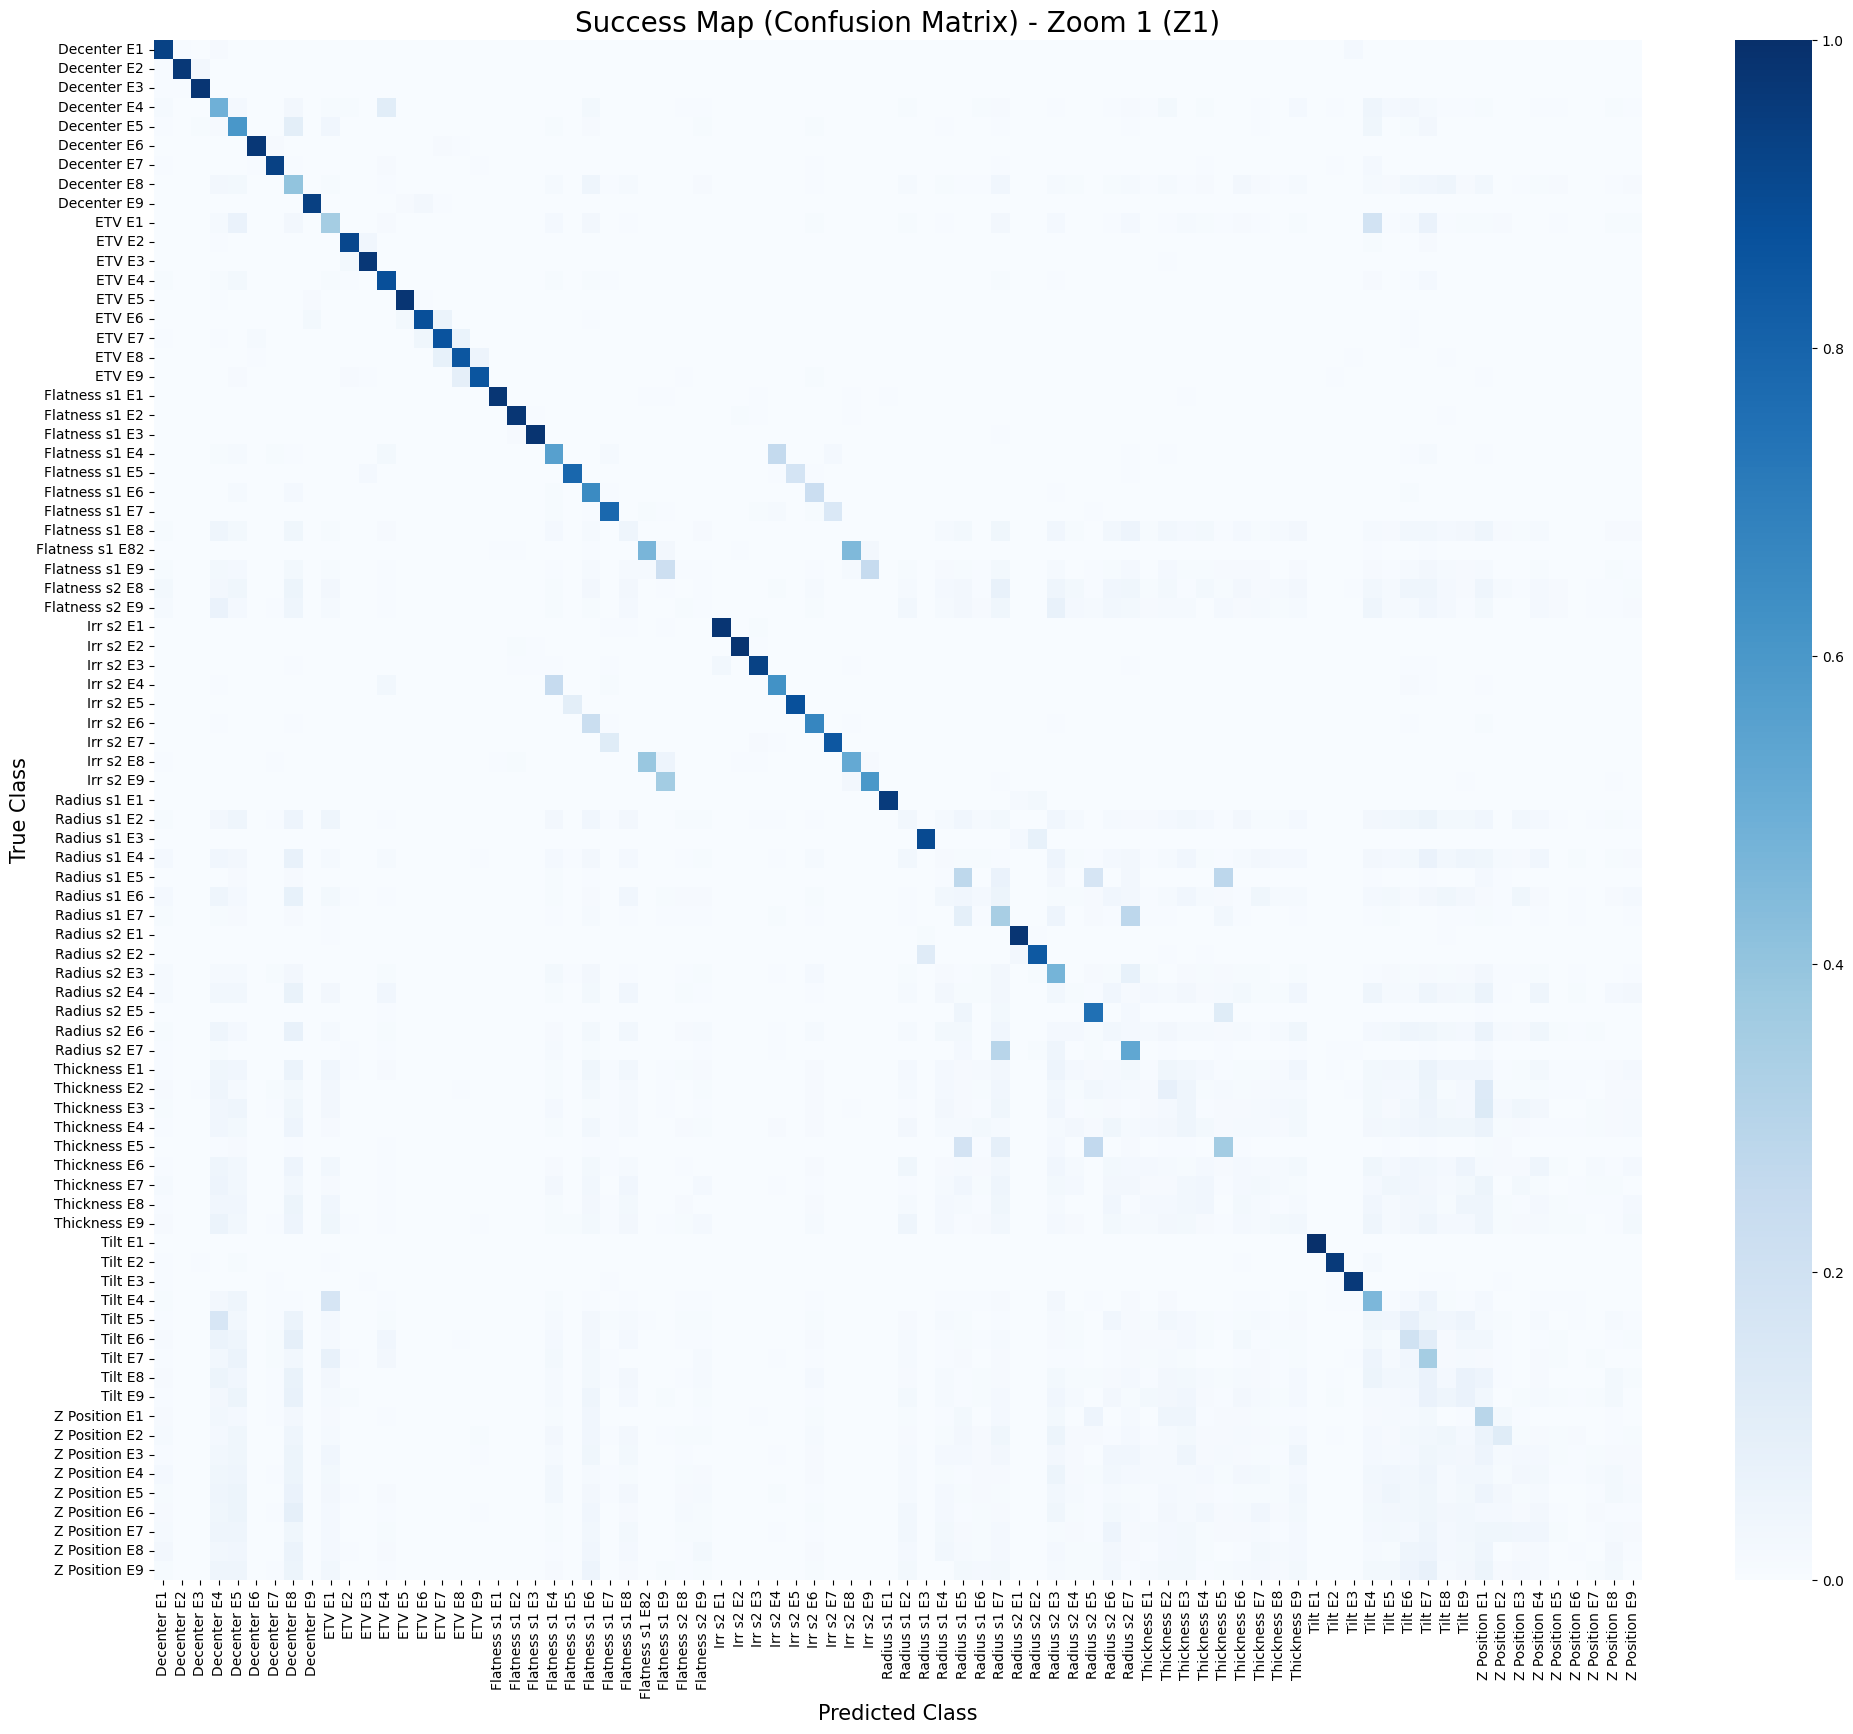

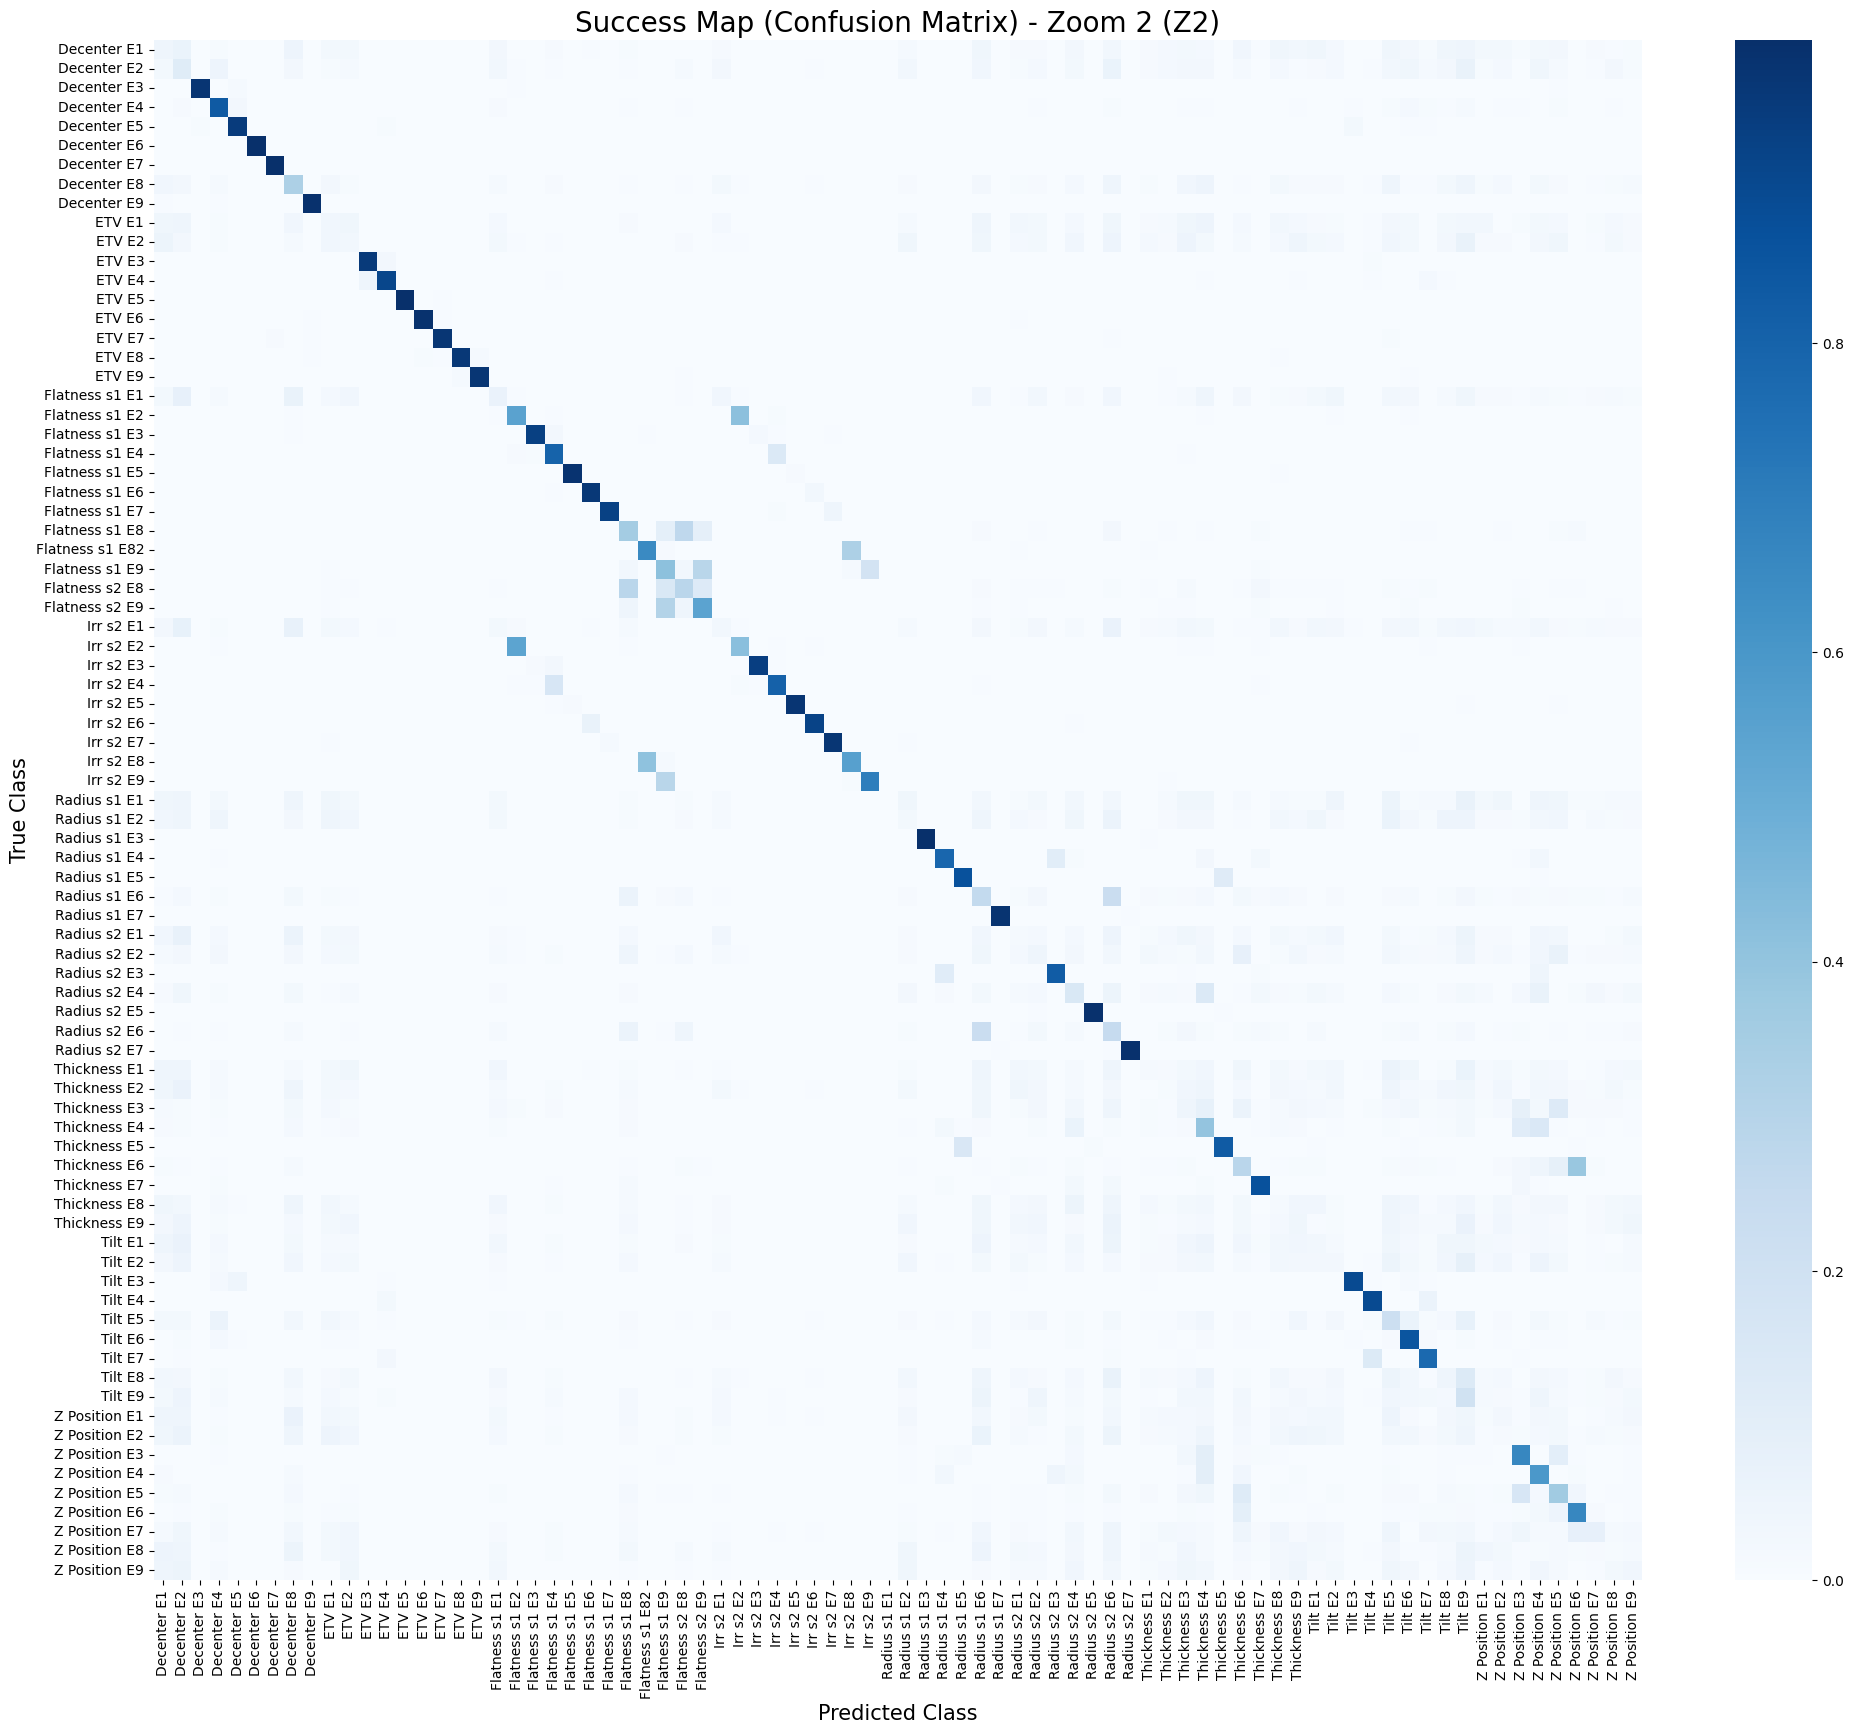

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_success_map(model, X_v, y_v_orig, le_zoom, title):
    # 1. הכנת הלייבלים המקומיים של הזום (0 עד N-1)
    y_v_new = le_zoom.transform(y_v_orig)

    # 2. ביצוע חיזוי
    y_pred = model.predict(X_v)

    # 3. יצירת מטריצת בלבול
    cm = confusion_matrix(y_v_new, y_pred)

    # 4. נרמול המטריצה כדי לראות אחוזי הצלחה (Recall) בכל שורה
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 5. ציור המפה
    plt.figure(figsize=(24, 20)) # גודל גדול בגלל 80 המחלקות
    sns.heatmap(cm_perc, annot=False, cmap='Blues',
                xticklabels=le_zoom.classes_,
                yticklabels=le_zoom.classes_)

    plt.title(f"Success Map (Confusion Matrix) - {title}", fontsize=20)
    plt.xlabel("Predicted Class", fontsize=15)
    plt.ylabel("True Class", fontsize=15)
    plt.show()

# הרצה עבור שני המודלים (שים לב שאנחנו משתמשים ב-le_z1 ו-le_z2 שנוצרו באימון)
if model_z1 is not None:
    plot_success_map(model_z1, X_va_z1, y_va_z1, le_z1, "Zoom 1 (Z1)")

if model_z2 is not None:
    plot_success_map(model_z2, X_va_z2, y_va_z2, le_z2, "Zoom 2 (Z2)")

The confusion matrices (success maps) for Z1 and Z2 show the models' per-class performance. Darker diagonal cells indicate high recall (correct predictions) for specific error types/elements, while off-diagonal patterns highlight misclassifications.
overall from the confusion matrices we can conclude the following:
* We have high recall (most points lay on the diagonal)
* recall ~ precision. this indicates a balanced and unbiased model. That is, the model predicts each error pretty much at the rate it appears in reality.
* Physical barrier: The situation where $FP = FN$ (false alarms equal misses) implies that the difficulty in prediction **stems from physical similarities between classes (for example, two lenses that affect the Zernica coefficients almost identically)**. The model simply "bets" between them equally because it lacks discriminative information.

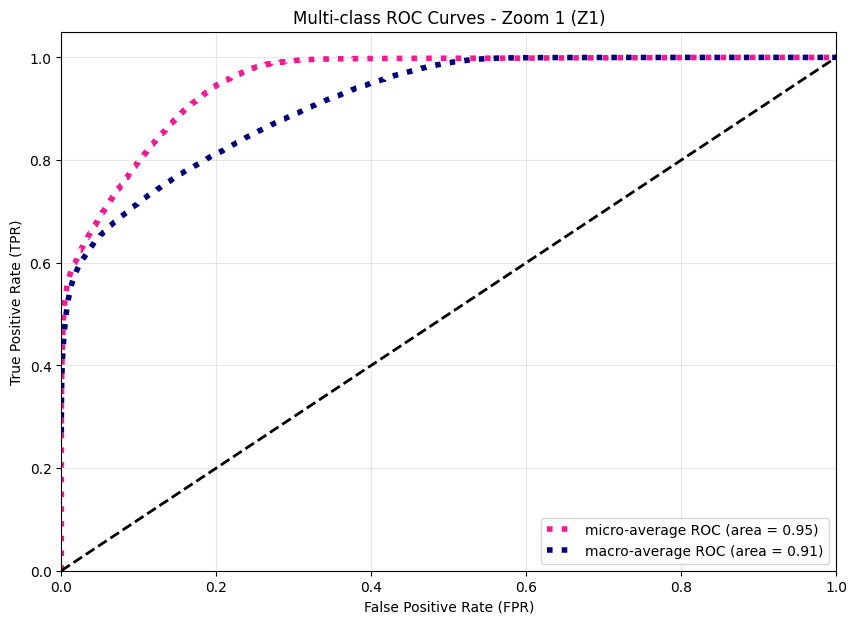

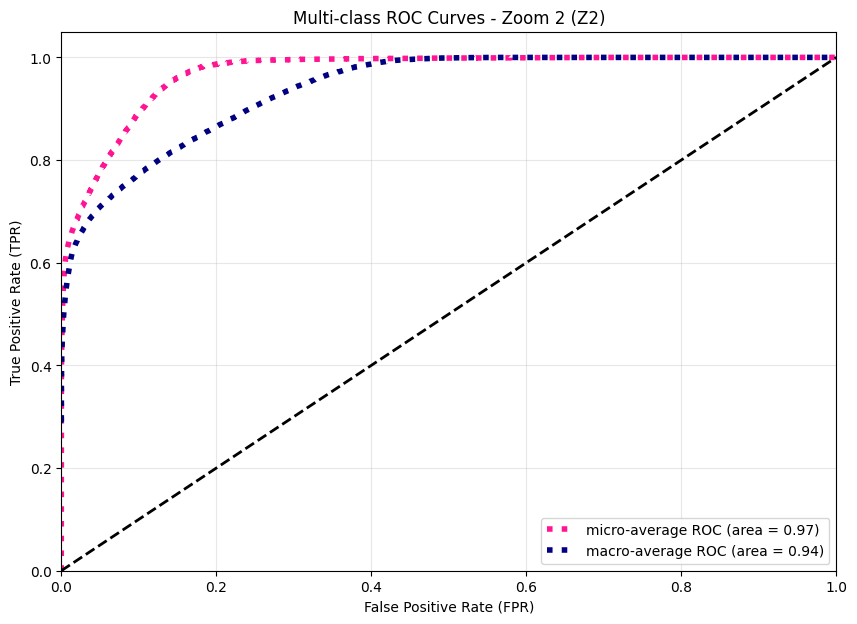

In [54]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc(model, X, y_true_names, le, title):
    # 1. Data preparation: Converting names to numbers and binarization (One-vs-Rest)
    y_true_idx = le.transform(y_true_names)
    n_classes = len(le.classes_)
    y_true_bin = label_binarize(y_true_idx, classes=np.arange(n_classes))

    # Get probabilities for each class
    y_score = model.predict_proba(X)

    # 2. Calculate ROC and AUC for each class separately (intermediate step)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 3. Calculate Micro-average (global average of all samples combined)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # 4. Calculate Macro-average (equal average of all classes, regardless of their size)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # 5. Plotting the graph
    plt.figure(figsize=(10, 7))

    # Micro-average line
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Macro-average line
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    # Random line (Chance)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Multi-class ROC Curves - {title}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Run for both models ---
if 'model_z1' in locals():
    plot_multiclass_roc(model_z1, X_va_z1, y_va_z1, le_z1, "Zoom 1 (Z1)")

if 'model_z2' in locals():
    plot_multiclass_roc(model_z2, X_va_z2, y_va_z2, le_z2, "Zoom 2 (Z2)")

Graphs:
* Micro: Gives equal weight to each sample.
* Macro: Gives equal weight to each class.

***The farther the curves are from the black dotted line (representing random guess) to the left upper corner (high TPR, low FPR) the better the model***

############################

**Conculsions:**
* Although the accuracy is 55%, the high AUC (around 0.9 and above) indicates that the model almost always places the correct answer.

* The fact that the Micro and Macro lines are close together shows that the model is not “cheating” by succeeding only in common classes, but rather exhibits similar and stable performance across all 80 error types.

* “Information quality” differences: The Z2 curves are generally better (closer to the left corner). This physically shows that the focal length of Zoom 2 produces more distinct Zernica signatures than Zoom 1.
############################

------------------------------------------------------

# Next, I try to find if I can surpass the results of XGBoost using "clever" neural network

## I'll start with a conventional neural network model:

In [55]:
from torch.utils.data import DataLoader, TensorDataset
import torch

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val_t), batch_size=256, shuffle=False)

Final Training - Accuracy: 0.4349, F1: 0.4349
Final Validation - Accuracy: 0.4355, F1: 0.4105


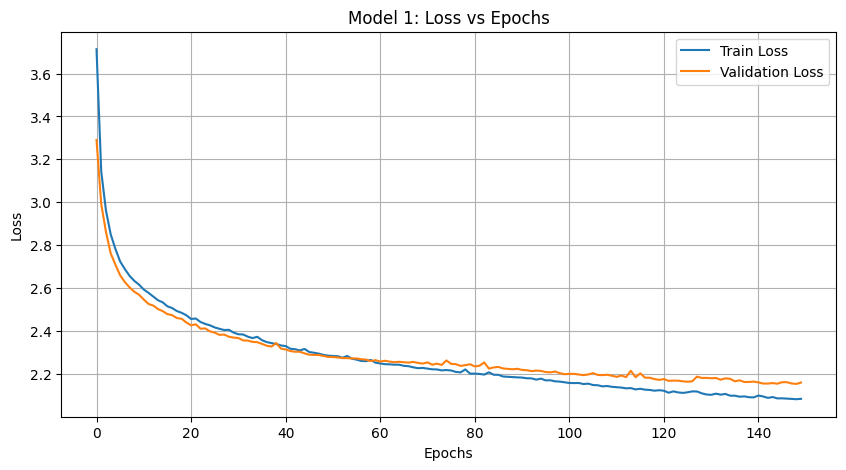

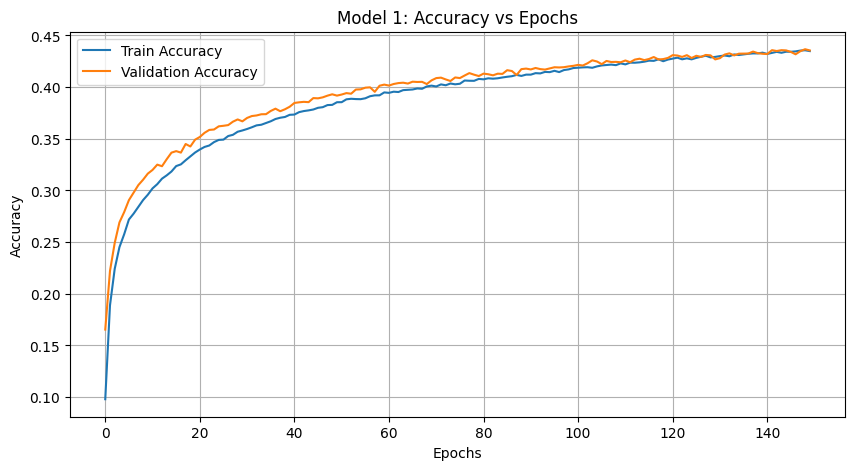

In [59]:
import torch.optim as optim

# --- 2. Model 1 Definition ---
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = Model1(X_train.shape[1], len(le_full.classes_))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# --- 3. Training Loop ---
epochs = 150
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_loader.dataset))
    train_accs.append(correct / total)

    model.eval()
    v_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            v_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            v_total += labels.size(0)
            v_correct += predicted.eq(labels).sum().item()

    val_losses.append(v_loss / len(val_loader.dataset))
    val_accs.append(v_correct / v_total)

# Final Metrics
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).argmax(dim=1).numpy()
    y_val_pred = model(X_val).argmax(dim=1).numpy()

train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Removed .numpy()
val_f1 = f1_score(y_val, y_val_pred, average='weighted')       # Removed .numpy()

print(f"Final Training - Accuracy: {train_accs[-1]:.4f}, F1: {train_f1:.4f}")
print(f"Final Validation - Accuracy: {val_accs[-1]:.4f}, F1: {val_f1:.4f}")

# --- 4. Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model 1: Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('model1_loss_plot.png')

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model 1: Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('model1_accuracy_plot.png')

In [60]:
print(type(X_train_scaled), X_train_scaled.shape)
print(type(y_train_type), y_train_type.shape)
print(type(le_full), len(le_full.classes_))

<class 'numpy.ndarray'> (120000, 38)
<class 'numpy.ndarray'> (120000,)
<class 'sklearn.preprocessing._label.LabelEncoder'> 80


--------------------------------------------------------
## Seems that the conventional neural network model gives are slightly less good than that of our XGBoost model. Let's see if we can surpass that

###*Each error in the 'name' column consists of [optical error]+[optical element], for example: 'Tilt E6' ([Tilt]+[E6])*

### The Model2TypeFirstNN model is a two-stage neural network. In the first stage, it predicts the error type. Then, in the second stage, it predicts the optical element, with this prediction being conditioned on the most likely error type determined in the first stage, using an embedding layer.

Epoch 01/30 | Train Loss: 4.2364, Val Loss: 4.0220 | Train Acc(name): 0.0474, Val Acc(name): 0.0696 | Train F1(w): 0.0286, Val F1(w): 0.0387 | Train __INVALID__: 0.28%, Val __INVALID__: 0.01%Type Acc: train=0.2209, val=0.2861 | 
Epoch 02/30 | Train Loss: 3.9143, Val Loss: 3.8301 | Train Acc(name): 0.0828, Val Acc(name): 0.0935 | Train F1(w): 0.0520, Val F1(w): 0.0600 | Train __INVALID__: 0.00%, Val __INVALID__: 0.01%Type Acc: train=0.3021, val=0.3280 | 
Epoch 03/30 | Train Loss: 3.7477, Val Loss: 3.6814 | Train Acc(name): 0.1141, Val Acc(name): 0.1252 | Train F1(w): 0.0875, Val F1(w): 0.1004 | Train __INVALID__: 0.01%, Val __INVALID__: 0.00%Type Acc: train=0.3386, val=0.3444 | 
Epoch 04/30 | Train Loss: 3.6179, Val Loss: 3.5880 | Train Acc(name): 0.1359, Val Acc(name): 0.1374 | Train F1(w): 0.1100, Val F1(w): 0.1084 | Train __INVALID__: 0.16%, Val __INVALID__: 0.14%Type Acc: train=0.3583, val=0.3583 | 
Epoch 05/30 | Train Loss: 3.5380, Val Loss: 3.5216 | Train Acc(name): 0.1509, Val Ac

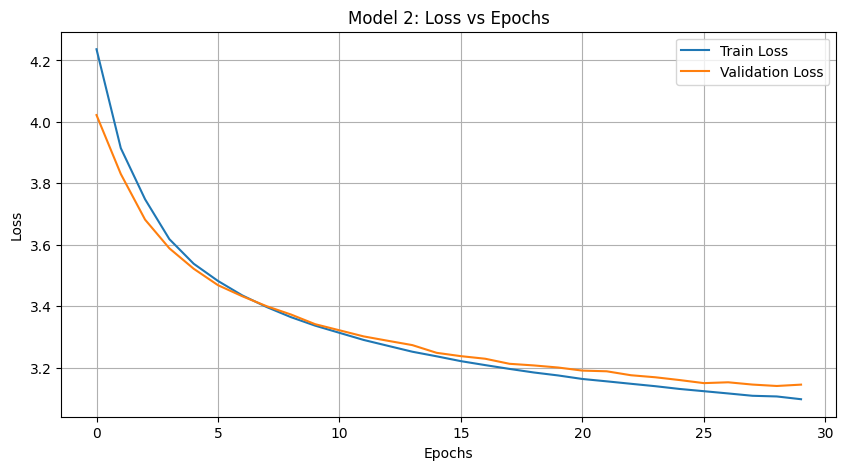

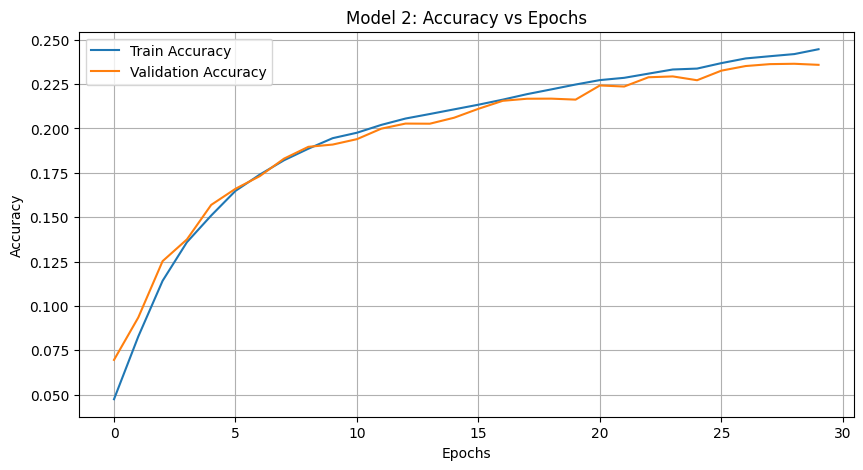

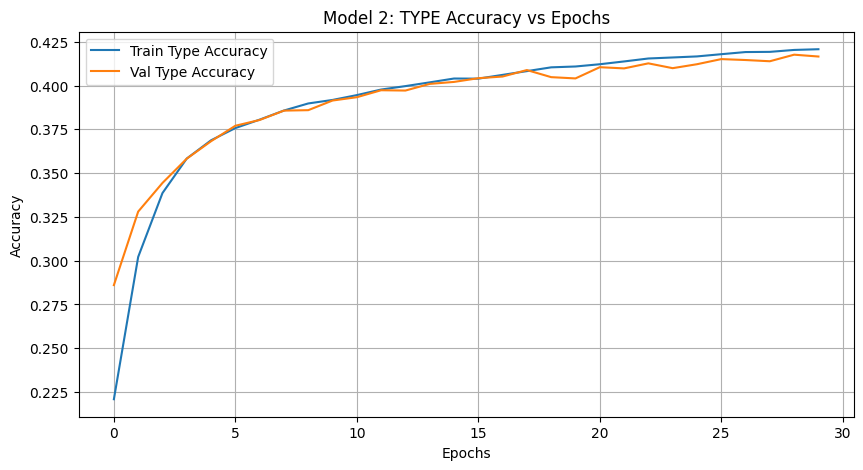


=== Final (Model 2) ===
Final Training   - Accuracy: 0.2447, F1: 0.2332, INVALID: 0.70%
Final Validation - Accuracy: 0.2359, F1: 0.2207, INVALID: 0.16%


In [62]:
# =========================
# Model 2 (Type -> Element) - Section 4.1 (Model-1 style, no ordering bugs)
# Requires existing from preprocessing cell:
# X_train_scaled, X_val_scaled
# y_train_type, y_train_elem, y_val_type, y_val_elem
# le_full, le_type, le_elem
# and Model2TypeFirstNN class definition
# =========================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ---- 0) device / model / loss / optim ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix: Use the correct class name and pass all required arguments
model2 = Model2TypeFirstNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_classes_type=NUM_CLASSES_TYPE,
    num_classes_elem=NUM_CLASSES_ELEM,
    embed_dim=EMBED_DIM,
    dropout=0.0
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

# ---- 1) loaders (no re-split / no re-scale) ----
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_type_t = torch.tensor(y_train_type, dtype=torch.long)
y_train_elem_t = torch.tensor(y_train_elem, dtype=torch.long)

y_val_type_t = torch.tensor(y_val_type, dtype=torch.long)
y_val_elem_t = torch.tensor(y_val_elem, dtype=torch.long)

train_loader_m2 = DataLoader(
    TensorDataset(X_train_t, y_train_type_t, y_train_elem_t),
    batch_size=512, shuffle=True
)
val_loader_m2 = DataLoader(
    TensorDataset(X_val_t, y_val_type_t, y_val_elem_t),
    batch_size=2048, shuffle=False
)

# ---- 2) valid combinations (for __INVALID__) ----
valid_full_names = set(le_full.classes_)

# ---- 3) training loop (metrics computed inside loader, like Model 1) ----
epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []
train_invalids, val_invalids = [], []
train_type_accs, val_type_accs = [], []

for epoch in range(1, epochs + 1):

    # -------- TRAIN --------
    model2.train()
    running_loss = 0.0
    n_total = 0
    type_correct, type_total = 0, 0


    y_true_all = []
    y_pred_all = []
    invalid_count = 0

    for xb, ytb, yeb in train_loader_m2:
        xb = xb.to(device)
        ytb = ytb.to(device)  # true type
        yeb = yeb.to(device)  # true element

        optimizer.zero_grad()
        type_logits, elem_logits = model2(xb)
        type_pred_t = type_logits.argmax(1)
        type_correct += (type_pred_t == ytb).sum().item()
        type_total   += ytb.size(0)


        loss = criterion(type_logits, ytb) + criterion(elem_logits, yeb)
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        n_total += bs

        # --- build TRUE/PRED name strings from THIS batch (no external ordering) ---
        type_pred = type_logits.argmax(1).detach().cpu().numpy()
        elem_pred = elem_logits.argmax(1).detach().cpu().numpy()

        type_true = ytb.detach().cpu().numpy()
        elem_true = yeb.detach().cpu().numpy()

        type_true_str = le_type.inverse_transform(type_true)
        elem_true_str = le_elem.inverse_transform(elem_true)
        name_true_str = [f"{t} {e}" for t, e in zip(type_true_str, elem_true_str)]

        type_pred_str = le_type.inverse_transform(type_pred)
        elem_pred_str = le_elem.inverse_transform(elem_pred)
        name_pred_str = []
        for t, e in zip(type_pred_str, elem_pred_str):
            s = f"{t} {e}"
            if s not in valid_full_names:
                s = "__INVALID__"
                invalid_count += 1
            name_pred_str.append(s)

        y_true_all.extend(name_true_str)
        y_pred_all.extend(name_pred_str)

    train_loss_epoch = running_loss / n_total
    train_acc_epoch = accuracy_score(y_true_all, y_pred_all)
    labels_union = np.unique(np.array(y_true_all + y_pred_all, dtype=object))
    train_f1_epoch = f1_score(y_true_all, y_pred_all, average="weighted", labels=labels_union)
    train_invalid_epoch = invalid_count / n_total

    train_type_acc_epoch = type_correct / max(1, type_total)
    train_type_accs.append(train_type_acc_epoch)


    train_losses.append(train_loss_epoch)
    train_accs.append(train_acc_epoch)
    train_f1s.append(train_f1_epoch)
    train_invalids.append(train_invalid_epoch)

    # -------- VALIDATION --------
    model2.eval()
    v_loss = 0.0
    v_total = 0
    v_type_correct, v_type_total = 0, 0

    y_true_all = []
    y_pred_all = []
    invalid_count = 0

    with torch.no_grad():
        for xb, ytb, yeb in val_loader_m2:
            xb = xb.to(device)
            ytb = ytb.to(device)
            yeb = yeb.to(device)

            type_logits, elem_logits = model2(xb)
            type_pred_t = type_logits.argmax(1)
            v_type_correct += (type_pred_t == ytb).sum().item()
            v_type_total   += ytb.size(0)

            loss = criterion(type_logits, ytb) + criterion(elem_logits, yeb)

            bs = xb.size(0)
            v_loss += loss.item() * bs
            v_total += bs

            type_pred = type_logits.argmax(1).cpu().numpy()
            elem_pred = elem_logits.argmax(1).cpu().numpy()

            type_true = ytb.cpu().numpy()
            elem_true = yeb.cpu().numpy()

            type_true_str = le_type.inverse_transform(type_true)
            elem_true_str = le_elem.inverse_transform(elem_true)
            name_true_str = [f"{t} {e}" for t, e in zip(type_true_str, elem_true_str)]

            type_pred_str = le_type.inverse_transform(type_pred)
            elem_pred_str = le_elem.inverse_transform(elem_pred)
            name_pred_str = []
            for t, e in zip(type_pred_str, elem_pred_str):
                s = f"{t} {e}"
                if s not in valid_full_names:
                    s = "__INVALID__"
                    invalid_count += 1
                name_pred_str.append(s)

            y_true_all.extend(name_true_str)
            y_pred_all.extend(name_pred_str)

    val_loss_epoch = v_loss / v_total
    val_type_acc_epoch = v_type_correct / max(1, v_type_total)
    val_type_accs.append(val_type_acc_epoch)

    val_acc_epoch = accuracy_score(y_true_all, y_pred_all)
    labels_union = np.unique(np.array(y_true_all + y_pred_all, dtype=object))
    val_f1_epoch = f1_score(y_true_all, y_pred_all, average="weighted", labels=labels_union)
    val_invalid_epoch = invalid_count / v_total

    val_losses.append(val_loss_epoch)
    val_accs.append(val_acc_epoch)
    val_f1s.append(val_f1_epoch)
    val_invalids.append(val_invalid_epoch)

    print(
        f"Epoch {epoch:02d}/{epochs} | "
        f"Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f} | "
        f"Train Acc(name): {train_acc_epoch:.4f}, Val Acc(name): {val_acc_epoch:.4f} | "
        f"Train F1(w): {train_f1_epoch:.4f}, Val F1(w): {val_f1_epoch:.4f} | "
        f"Train __INVALID__: {100*train_invalid_epoch:.2f}%, Val __INVALID__: {100*val_invalid_epoch:.2f}%"
        f"Type Acc: train={train_type_acc_epoch:.4f}, val={val_type_acc_epoch:.4f} | "
    )

# ---- 4) plots: Loss + Accuracy vs Epochs (like Model 1) ----
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Model 2: Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Model 2: Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_type_accs, label="Train Type Accuracy")
plt.plot(val_type_accs, label="Val Type Accuracy")
plt.title("Model 2: TYPE Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


print("\n=== Final (Model 2) ===")
print(f"Final Training   - Accuracy: {train_accs[-1]:.4f}, F1: {train_f1s[-1]:.4f}, INVALID: {100*train_invalids[-1]:.2f}%")
print(f"Final Validation - Accuracy: {val_accs[-1]:.4f}, F1: {val_f1s[-1]:.4f}, INVALID: {100*val_invalids[-1]:.2f}%")

## Type-only NN with J = J_type (only)
### The TypeOnlyNN model is a straightforward neural network designed to predict only the error type. It takes the input features and processes them through a few linear layers with ReLU activations to directly output logits for the different error types. It does not consider the optical element or any cascaded prediction.

Epoch 01/30 | TypeOnly Loss: train=2.0834, val=1.9516 | Acc: train=0.2196, val=0.2832 | F1(w): train=0.2008, val=0.2559
Epoch 02/30 | TypeOnly Loss: train=1.8803, val=1.8268 | Acc: train=0.3026, val=0.3258 | F1(w): train=0.2840, val=0.2972
Epoch 03/30 | TypeOnly Loss: train=1.7818, val=1.7521 | Acc: train=0.3366, val=0.3406 | F1(w): train=0.3260, val=0.3263
Epoch 04/30 | TypeOnly Loss: train=1.7212, val=1.7079 | Acc: train=0.3534, val=0.3550 | F1(w): train=0.3484, val=0.3317
Epoch 05/30 | TypeOnly Loss: train=1.6834, val=1.6755 | Acc: train=0.3648, val=0.3710 | F1(w): train=0.3623, val=0.3676
Epoch 06/30 | TypeOnly Loss: train=1.6574, val=1.6533 | Acc: train=0.3751, val=0.3734 | F1(w): train=0.3753, val=0.3725
Epoch 07/30 | TypeOnly Loss: train=1.6367, val=1.6384 | Acc: train=0.3791, val=0.3799 | F1(w): train=0.3800, val=0.3836
Epoch 08/30 | TypeOnly Loss: train=1.6213, val=1.6227 | Acc: train=0.3829, val=0.3846 | F1(w): train=0.3853, val=0.3849
Epoch 09/30 | TypeOnly Loss: train=1.608

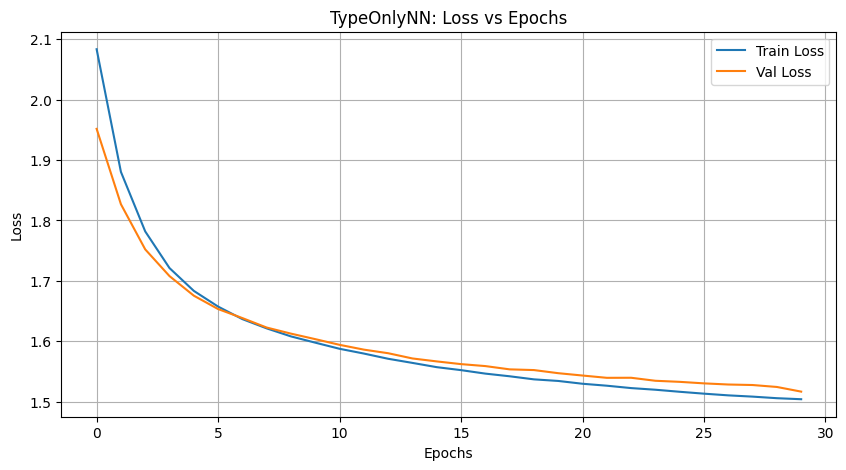

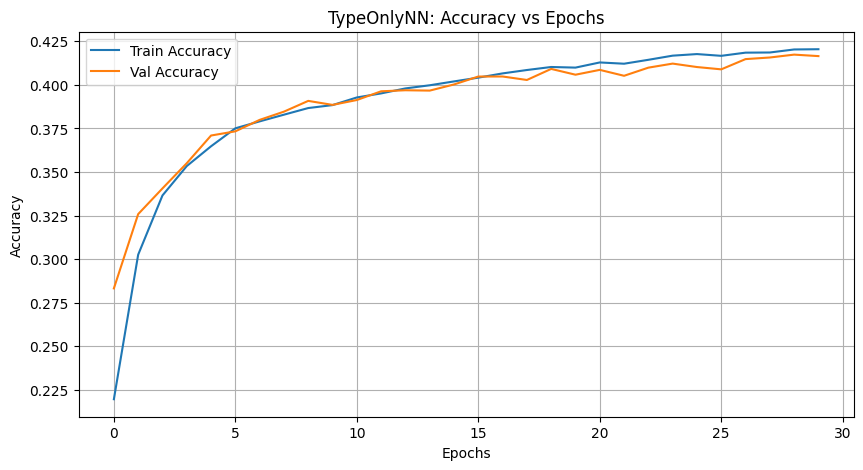


=== Final (TypeOnlyNN) ===
Train Type Acc: 0.4205, F1(w): 0.4276
Val   Type Acc: 0.4165, F1(w): 0.4150


In [64]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class TypeOnlyNN(nn.Module):
    def __init__(self, input_dim=38, hidden=128, n_types=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_types)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader_type = DataLoader(
    TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                  torch.tensor(y_train_type, dtype=torch.long)),
    batch_size=512, shuffle=True
)
val_loader_type = DataLoader(
    TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                  torch.tensor(y_val_type, dtype=torch.long)),
    batch_size=2048, shuffle=False
)

type_only = TypeOnlyNN(input_dim=38, hidden=128, n_types=len(le_type.classes_)).to(device)
criterion_type = nn.CrossEntropyLoss()
optimizer_type = optim.Adam(type_only.parameters(), lr=1e-3)

epochs_type = 30
typeonly_train_losses, typeonly_val_losses = [], []
typeonly_train_accs,   typeonly_val_accs   = [], []
typeonly_train_f1s,    typeonly_val_f1s    = [], []

for epoch in range(1, epochs_type + 1):
    # ---- train ----
    type_only.train()
    running_loss, n = 0.0, 0
    y_true, y_pred = [], []

    for xb, ytb in train_loader_type:
        xb, ytb = xb.to(device), ytb.to(device)

        optimizer_type.zero_grad()
        logits = type_only(xb)
        loss = criterion_type(logits, ytb)
        loss.backward()
        optimizer_type.step()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        n += bs

        pred = logits.argmax(1).detach().cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(ytb.detach().cpu().numpy())

    tr_loss = running_loss / n
    tr_acc  = accuracy_score(y_true, y_pred)
    tr_f1   = f1_score(y_true, y_pred, average="weighted")

    # ---- val ----
    type_only.eval()
    v_loss, v_n = 0.0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, ytb in val_loader_type:
            xb, ytb = xb.to(device), ytb.to(device)
            logits = type_only(xb)
            loss = criterion_type(logits, ytb)

            bs = xb.size(0)
            v_loss += loss.item() * bs
            v_n += bs

            pred = logits.argmax(1).cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(ytb.cpu().numpy())

    va_loss = v_loss / v_n
    va_acc  = accuracy_score(y_true, y_pred)
    va_f1   = f1_score(y_true, y_pred, average="weighted")

    typeonly_train_losses.append(tr_loss); typeonly_val_losses.append(va_loss)
    typeonly_train_accs.append(tr_acc);   typeonly_val_accs.append(va_acc)
    typeonly_train_f1s.append(tr_f1);     typeonly_val_f1s.append(va_f1)

    print(f"Epoch {epoch:02d}/{epochs_type} | TypeOnly Loss: train={tr_loss:.4f}, val={va_loss:.4f} | "
          f"Acc: train={tr_acc:.4f}, val={va_acc:.4f} | F1(w): train={tr_f1:.4f}, val={va_f1:.4f}")

# Graphs (as in section 4.1)
plt.figure(figsize=(10,5))
plt.plot(typeonly_train_losses, label="Train Loss")
plt.plot(typeonly_val_losses, label="Val Loss")
plt.title("TypeOnlyNN: Loss vs Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.plot(typeonly_train_accs, label="Train Accuracy")
plt.plot(typeonly_val_accs, label="Val Accuracy")
plt.title("TypeOnlyNN: Accuracy vs Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

print("\n=== Final (TypeOnlyNN) ===")
print(f"Train Type Acc: {typeonly_train_accs[-1]:.4f}, F1(w): {typeonly_train_f1s[-1]:.4f}")
print(f"Val   Type Acc: {typeonly_val_accs[-1]:.4f}, F1(w): {typeonly_val_f1s[-1]:.4f}")

# **Conclusions:**
## The separation of predicting each error by its physical mechanism: its optical error + the optical element wasn't sucssesfull.
## In fact, from comparing the two-stage model with a regular NN only on the optical error classification it seems that **when the loss of the optical error depends on the loss of the optical element it only interffered with the model's ability to learn**.

##**We'll now try the oposite: predicting the optical element first, than the optical error**

Epoch 01/30 | Train Loss: 4.2309, Val Loss: 4.0603 | Name Acc: train=0.0376, val=0.0536 | Elem Acc: train=0.1653, val=0.1921 | Type Acc: train=0.2210, val=0.2531 | __INVALID__: train=0.01%, val=0.00%
Epoch 02/30 | Train Loss: 3.9712, Val Loss: 3.8876 | Name Acc: train=0.0725, val=0.0902 | Elem Acc: train=0.2162, val=0.2338 | Type Acc: train=0.2791, val=0.2996 | __INVALID__: train=0.00%, val=0.01%
Epoch 03/30 | Train Loss: 3.8014, Val Loss: 3.7394 | Name Acc: train=0.1017, val=0.1078 | Elem Acc: train=0.2438, val=0.2505 | Type Acc: train=0.3178, val=0.3279 | __INVALID__: train=0.18%, val=0.41%
Epoch 04/30 | Train Loss: 3.6795, Val Loss: 3.6387 | Name Acc: train=0.1165, val=0.1245 | Elem Acc: train=0.2595, val=0.2645 | Type Acc: train=0.3417, val=0.3474 | __INVALID__: train=0.13%, val=0.07%
Epoch 05/30 | Train Loss: 3.6076, Val Loss: 3.5913 | Name Acc: train=0.1285, val=0.1316 | Elem Acc: train=0.2739, val=0.2794 | Type Acc: train=0.3564, val=0.3622 | __INVALID__: train=0.17%, val=0.51%


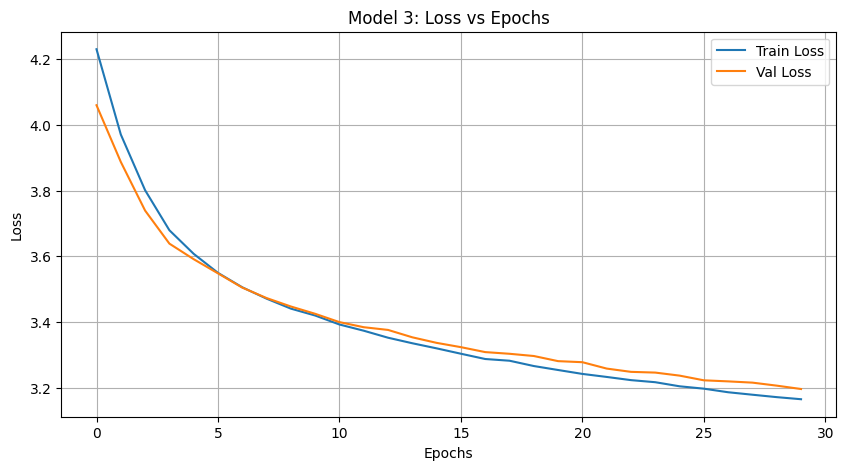

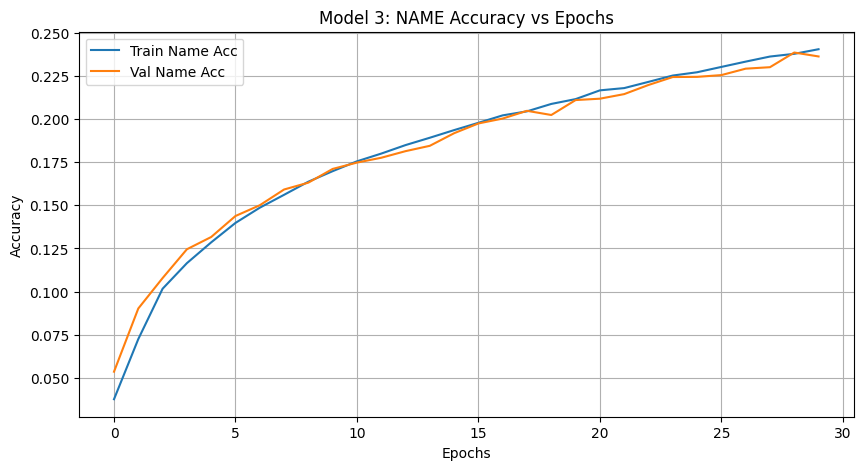

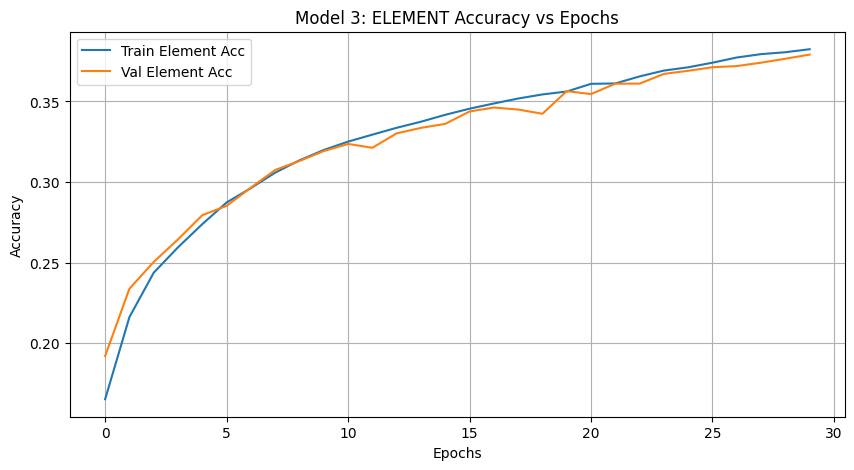

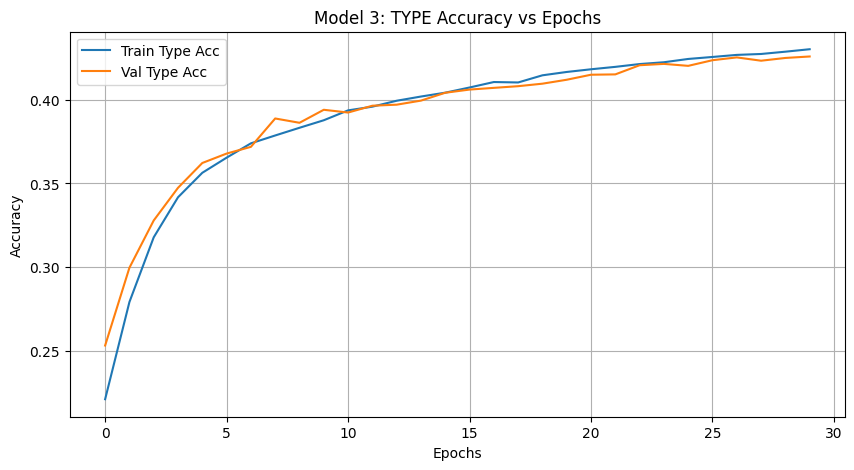


=== Final (Model 3) ===
Final Train Name Acc: 0.2404 | INVALID: 0.27%
Final Val   Name Acc: 0.2362 | INVALID: 0.47%
Final Train Elem Acc: 0.3824 | Train Type Acc: 0.4302
Final Val   Elem Acc: 0.3790 | Val   Type Acc: 0.4259


In [66]:
# =========================
# Model 3 (Element -> Type) - Section 4.1 (Model-2 style, no ordering bugs)
# Uses existing: X_train_scaled/X_val_scaled,
#               y_train_elem/y_train_type, y_val_elem/y_val_type,
#               le_full/le_type/le_elem, Model3ElementFirstNN
# =========================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3 = Model3ElementFirstNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_classes_elem=NUM_CLASSES_ELEM,
    num_classes_type=NUM_CLASSES_TYPE,
    embed_dim=EMBED_DIM,
    dropout=0.0
).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-3)

# ---- loaders (order matches model3: X, elem_label, type_label) ----
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_elem_t = torch.tensor(y_train_elem, dtype=torch.long)
y_train_type_t = torch.tensor(y_train_type, dtype=torch.long)

y_val_elem_t = torch.tensor(y_val_elem, dtype=torch.long)
y_val_type_t = torch.tensor(y_val_type, dtype=torch.long)

train_loader_m3 = DataLoader(
    TensorDataset(X_train_t, y_train_elem_t, y_train_type_t),
    batch_size=512, shuffle=True
)
val_loader_m3 = DataLoader(
    TensorDataset(X_val_t, y_val_elem_t, y_val_type_t),
    batch_size=2048, shuffle=False
)

valid_full_names = set(le_full.classes_)

epochs = 30
train_losses, val_losses = [], []
train_name_accs, val_name_accs = [], []
train_elem_accs, val_elem_accs = [], []
train_type_accs, val_type_accs = [], []
train_invalids, val_invalids = [], []

for epoch in range(1, epochs + 1):

    # -------- TRAIN --------
    model3.train()
    running_loss = 0.0
    n_total = 0

    elem_correct = type_correct = 0
    elem_total = type_total = 0

    y_true_all = []
    y_pred_all = []
    invalid_count = 0

    for xb, yeb, ytb in train_loader_m3:
        xb = xb.to(device)
        yeb = yeb.to(device)  # true element
        ytb = ytb.to(device)  # true type

        optimizer.zero_grad()
        elem_logits, type_logits = model3(xb)

        loss = criterion(elem_logits, yeb) + criterion(type_logits, ytb)
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        n_total += bs

        # --- element/type accuracy (head-only) ---
        elem_pred_t = elem_logits.argmax(1)
        type_pred_t = type_logits.argmax(1)

        elem_correct += (elem_pred_t == yeb).sum().item()
        type_correct += (type_pred_t == ytb).sum().item()
        elem_total   += yeb.size(0)
        type_total   += ytb.size(0)

        # --- build TRUE/PRED name strings from THIS batch (no external ordering) ---
        elem_true = yeb.detach().cpu().numpy()
        type_true = ytb.detach().cpu().numpy()
        elem_pred = elem_pred_t.detach().cpu().numpy()
        type_pred = type_pred_t.detach().cpu().numpy()

        elem_true_str = le_elem.inverse_transform(elem_true)
        type_true_str = le_type.inverse_transform(type_true)
        name_true_str = [f"{t} {e}" for t, e in zip(type_true_str, elem_true_str)]

        elem_pred_str = le_elem.inverse_transform(elem_pred)
        type_pred_str = le_type.inverse_transform(type_pred)
        name_pred_str = []
        for t, e in zip(type_pred_str, elem_pred_str):
            s = f"{t} {e}"
            if s not in valid_full_names:
                s = "__INVALID__"
                invalid_count += 1
            name_pred_str.append(s)

        y_true_all.extend(name_true_str)
        y_pred_all.extend(name_pred_str)

    train_loss_epoch = running_loss / n_total
    train_name_acc_epoch = accuracy_score(y_true_all, y_pred_all)
    train_elem_acc_epoch = elem_correct / max(1, elem_total)
    train_type_acc_epoch = type_correct / max(1, type_total)
    train_invalid_epoch   = invalid_count / n_total

    train_losses.append(train_loss_epoch)
    train_name_accs.append(train_name_acc_epoch)
    train_elem_accs.append(train_elem_acc_epoch)
    train_type_accs.append(train_type_acc_epoch)
    train_invalids.append(train_invalid_epoch)

    # -------- VALIDATION --------
    model3.eval()
    v_loss = 0.0
    v_total = 0

    elem_correct = type_correct = 0
    elem_total = type_total = 0

    y_true_all = []
    y_pred_all = []
    invalid_count = 0

    with torch.no_grad():
        for xb, yeb, ytb in val_loader_m3:
            xb = xb.to(device)
            yeb = yeb.to(device)
            ytb = ytb.to(device)

            elem_logits, type_logits = model3(xb)
            loss = criterion(elem_logits, yeb) + criterion(type_logits, ytb)

            bs = xb.size(0)
            v_loss += loss.item() * bs
            v_total += bs

            elem_pred_t = elem_logits.argmax(1)
            type_pred_t = type_logits.argmax(1)

            elem_correct += (elem_pred_t == yeb).sum().item()
            type_correct += (type_pred_t == ytb).sum().item()
            elem_total   += yeb.size(0)
            type_total   += ytb.size(0)

            elem_true = yeb.cpu().numpy()
            type_true = ytb.cpu().numpy()
            elem_pred = elem_pred_t.cpu().numpy()
            type_pred = type_pred_t.cpu().numpy()

            elem_true_str = le_elem.inverse_transform(elem_true)
            type_true_str = le_type.inverse_transform(type_true)
            name_true_str = [f"{t} {e}" for t, e in zip(type_true_str, elem_true_str)]

            elem_pred_str = le_elem.inverse_transform(elem_pred)
            type_pred_str = le_type.inverse_transform(type_pred)
            name_pred_str = []
            for t, e in zip(type_pred_str, elem_pred_str):
                s = f"{t} {e}"
                if s not in valid_full_names:
                    s = "__INVALID__"
                    invalid_count += 1
                name_pred_str.append(s)

            y_true_all.extend(name_true_str)
            y_pred_all.extend(name_pred_str)

    val_loss_epoch = v_loss / v_total
    val_name_acc_epoch = accuracy_score(y_true_all, y_pred_all)
    val_elem_acc_epoch = elem_correct / max(1, elem_total)
    val_type_acc_epoch = type_correct / max(1, type_total)
    val_invalid_epoch  = invalid_count / v_total

    val_losses.append(val_loss_epoch)
    val_name_accs.append(val_name_acc_epoch)
    val_elem_accs.append(val_elem_acc_epoch)
    val_type_accs.append(val_type_acc_epoch)
    val_invalids.append(val_invalid_epoch)

    print(
        f"Epoch {epoch:02d}/{epochs} | "
        f"Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f} | "
        f"Name Acc: train={train_name_acc_epoch:.4f}, val={val_name_acc_epoch:.4f} | "
        f"Elem Acc: train={train_elem_acc_epoch:.4f}, val={val_elem_acc_epoch:.4f} | "
        f"Type Acc: train={train_type_acc_epoch:.4f}, val={val_type_acc_epoch:.4f} | "
        f"__INVALID__: train={100*train_invalid_epoch:.2f}%, val={100*val_invalid_epoch:.2f}%"
    )

# ---- plots ----
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Model 3: Loss vs Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_name_accs, label="Train Name Acc")
plt.plot(val_name_accs, label="Val Name Acc")
plt.title("Model 3: NAME Accuracy vs Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_elem_accs, label="Train Element Acc")
plt.plot(val_elem_accs, label="Val Element Acc")
plt.title("Model 3: ELEMENT Accuracy vs Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_type_accs, label="Train Type Acc")
plt.plot(val_type_accs, label="Val Type Acc")
plt.title("Model 3: TYPE Accuracy vs Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()

print("\n=== Final (Model 3) ===")
print(f"Final Train Name Acc: {train_name_accs[-1]:.4f} | INVALID: {100*train_invalids[-1]:.2f}%")
print(f"Final Val   Name Acc: {val_name_accs[-1]:.4f} | INVALID: {100*val_invalids[-1]:.2f}%")
print(f"Final Train Elem Acc: {train_elem_accs[-1]:.4f} | Train Type Acc: {train_type_accs[-1]:.4f}")
print(f"Final Val   Elem Acc: {val_elem_accs[-1]:.4f} | Val   Type Acc: {val_type_accs[-1]:.4f}")

## It gives the same results as model 2...